In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)

print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-12 09:20


In [2]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
CoFFE = pd.read_parquet('../data/structure_annotation.parquet').reset_index()
emapper = pd.read_csv('../data/Slacustris_eggnog.tsv', sep='\t')

Now keep only the relevant columns:

In [4]:
CoFFE = CoFFE[['isoform', 'query', 'query length', 'protein_id', 'MSA size', 'seq. id.', 'bit score', 'Preferred_name', 'Description', 'plddt']].copy()
emapper = emapper[['protein_id', 'Preferred_name', 'Description']].copy()

Rename so that we have no trouble following them in the merged table, and join:

In [5]:
CoFFE.columns = ['isoform', 'query', 'query length', 'protein_id', 'MSA size', 'CoFFE %seq. id.', 'CoFFE bit score', 'CoFFE name', 'CoFFE description', 'plddt']
emapper.columns = ['protein_id', 'Emapper name', 'Emapper description']

In [6]:
annotation = CoFFE.set_index('protein_id').join(emapper.set_index('protein_id'))

Let's make sure everything went well:

In [7]:
CoFFE.shape, emapper.shape, annotation.shape

((41943, 10), (17990, 3), (41943, 11))

All the lengths are as they should

Let's take a look at the final LUT we created, and compare how many proteins are _not_ in it; those are the unannotated ones:

In [8]:
lut = pd.read_csv('../data/spongilla_lut.tsv', sep='\t')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
keep = ~annotation.index.isin(lut['protein_id'])

In [10]:
np.sum(keep)

15312

In [11]:
def exists(df, column):
    return ~((df[column].isnull()) | (df[column] == '-'))

In [12]:
coffe_name = exists(annotation, 'CoFFE name')
coffe_desc = exists(annotation, 'CoFFE description')
emapp_name = exists(annotation, 'Emapper name')
emapp_desc = exists(annotation, 'Emapper description')

coffe_annot = coffe_name | coffe_desc
emapp_annot = emapp_name | emapp_desc

In [13]:
overview = pd.DataFrame([coffe_annot, emapp_annot], index=['CoFFE', 'Emapper']).T

In [14]:
overview.groupby(['CoFFE', 'Emapper']).size()

CoFFE  Emapper
False  False        410
       True          37
True   False      24103
       True       17393
dtype: int64

In [15]:
unknown = ~(coffe_annot | emapp_annot).values
long = (annotation['query length'] > 100).values
small_msa = (annotation['MSA size'] < 50).values
confident = (annotation['plddt'] > 90).values
less_confident = ((annotation['plddt'] > 70) & (annotation['plddt'] <= 90)).values

In [16]:
(unknown & long & small_msa & confident)

array([False, False, False, ..., False, False, False])

In [17]:
np.sum(unknown & (less_confident | confident))

316

\<manual inspection of predicted structures\>

These are the query IDs that didn't form long helices:

In [18]:
keep1 = [10352, 10353, 10354, 12989, 12991, 12992, 26984]
keep2 = [768, 988, 1640, 4785, 4786, 4787, 5394, 6647, 6648, 10306, 12988, 12990, 13936, 13937, 13938,
        13939, 13940, 18020, 19456, 23114, 25195, 26061, 27314, 28239, 28240, 31563, 32481, 39806]
keep = keep1 + keep2

## unknown, $pLDDT>70$

We looked up the proteins that didn't form long helices in SwissProt (MMseqs2) and NR (BLAST). We record the hits no matter the e-value, since we are interested in finding novel structures:

In [19]:
add = {
    'c103626_g1_i1': 'DD3-3',
    'c104256_g1_i2': 'CRN-like',
    'c88005_g3_i1': 'hemopexin repeat-containing protein',
    'c94352_g2_i1': 'DD3-3',
    'c89711_g2_i1': 'DD3-3',
    'c89711_g1_i1': 'DD3-3',
    'c112476_g1_i1': 'DD3-3',
    'c101972_g1_i1': 'DD3-3',
    'c102584_g1_i1': 'DD3-3',
    'c88419_g1_i1': 'CRN5',
    'c104256_g1_i1': 'CRN5',
    'c98985_g1_i2': 'XPO5 (Exportin-5)',
    'c70965_g1_i1': 'pinocchio',
    'c104453_g2_i1': 'Spherulin-2A',
    'c102197_g1_i3': 'bamB',
    'c93555_g2_i2': '?',
    'c86044_g1_i1': '?',
    'c83472_g1_i1': '?',
    'c108675_g1_i1': '?',
    'c104453_g3_i1': 'follicular epithelium yolk protein subunit [Methanosarcina barkeri]',
    'c103612_g1_i1': 'kinesin-like protein KIF23',
    'c100331_g2_i1': 'hydralysin-2-like',
    'c100429_g1_i1': '?',
    'c100701_g1_i2': '?'
}
add = pd.DataFrame(index=add.keys(), data=add.values(), columns=['SwissProt+BLASTp'])
robust = CoFFE[CoFFE['query'].isin(keep)].sort_values(['isoform', 'plddt'], ascending=False).copy()

In [20]:
robust = robust.set_index('isoform').join(add)

In [21]:
robust.shape

(35, 10)

In [22]:
robust

query  query length  protein_id  MSA size  CoFFE %seq. id.  \
isoform                                                                     
c98985_g1_i2   39806            73       37037    1852.0            0.138   
c94352_g2_i1   32481           127       21960    1725.0            0.500   
c93555_g2_i2   31563            77       20188     439.0            0.109   
c89711_g2_i1   28240            75       14128    2340.0            0.611   
c89711_g1_i1   28239           144       14126    2424.0            0.441   
c88419_g1_i1   27314           154       12523     462.0            0.337   
c88005_g3_i1   26984           130       11884    3213.0            0.274   
c86044_g1_i1   26061            87       10206    7052.0            0.077   
c83472_g1_i1   25195            98        8763     553.0            0.177   
c70965_g1_i1   23114           169        5248     299.0            0.209   
c112476_g1_i1  19456           179       90299    1450.0            0.352   
c108675_g1_i1  18020            73       87816    3174.0            0.224   
c104453_g3_i1  13940           182       77373     341.0            0.117   
c104453_g2_i4  13939           236       77371     374.0            0.183   
c104453_g2_i3  13938           340       77369     378.0            0.185   
c104453_g2_i2  13937           280       77367     356.0            0.172   
c104453_g2_i1  13936           359       77365     368.0            0.177   
c104256_g1_i6  12992           253       74801     196.0            0.275   
c104256_g1_i4  12991           332       74798     158.0            0.263   
c104256_g1_i3  12990           336       74796     167.0            0.262   
c104256_g1_i2  12989           299       74794     184.0            0.267   
c104256_g1_i1  12988           375       74792     163.0            0.272   
c103626_g2_i1  10354           667       67395    3427.0            0.326   
c103626_g1_i2  10353           670       67400    3424.0            0.329   
c103626_g1_i1  10352           670       67391    3392.0            0.324   
c103612_g1_i1  10306            89       67226    1253.0            0.152   
c102584_g1_i2   6648           187       57711    1994.0            0.416   
c102584_g1_i1   6647           578       57709    3328.0            0.355   
c102197_g1_i3   5394           312       54585     257.0            0.179   
c101972_g1_i3   4787           778       53045    3481.0            0.378   
c101972_g1_i2   4786           778       53043    3481.0            0.378   
c101972_g1_i1   4785           778       53041    3481.0            0.378   
c100701_g1_i2   1640            69       45516       1.0            0.123   
c100429_g1_i1    988            79       43996    1098.0            0.152   
c100331_g2_i1    768           281       43509      27.0            0.219   

               CoFFE bit score CoFFE name CoFFE description      plddt  \
isoform                                                                  
c98985_g1_i2              45.0          -                 -  70.124932   
c94352_g2_i1             299.0          -                 -  86.067008   
c93555_g2_i2              80.0          -                 -  87.778701   
c89711_g2_i1             210.0          -                 -  77.482133   
c89711_g1_i1             380.0          -                 -  86.735417   
c88419_g1_i1             580.0          -                 -  85.018636   
c88005_g3_i1             363.0          -                 -  94.662385   
c86044_g1_i1              90.0          -                 -  88.877931   
c83472_g1_i1              90.0          -                 -  84.775102   
c70965_g1_i1             354.0          -                 -  77.626450   
c112476_g1_i1            434.0          -                 -  83.192514   
c108675_g1_i1             51.0          -                 -  78.172329   
c104453_g3_i1            298.0          -                 -  70.545165   
c104453_g2_i4            594.0          -              

The best candidates therefore are these. They are on the short side, but some of them have impressively big MSAs. Possibly artifacts or non-functional proteins, but worth looking at nonetheless. May be interesting to see what their MSAs are made of (phylogenetic distribution).

In [23]:
robust[robust['SwissProt+BLASTp'] == '?']

query  query length  protein_id  MSA size  CoFFE %seq. id.  \
isoform                                                                     
c93555_g2_i2   31563            77       20188     439.0            0.109   
c86044_g1_i1   26061            87       10206    7052.0            0.077   
c83472_g1_i1   25195            98        8763     553.0            0.177   
c108675_g1_i1  18020            73       87816    3174.0            0.224   
c100701_g1_i2   1640            69       45516       1.0            0.123   
c100429_g1_i1    988            79       43996    1098.0            0.152   

               CoFFE bit score CoFFE name CoFFE description      plddt  \
isoform                                                                  
c93555_g2_i2              80.0          -                 -  87.778701   
c86044_g1_i1              90.0          -                 -  88.877931   
c83472_g1_i1              90.0          -                 -  84.775102   
c108675_g1_i1             51.0          -                 -  78.172329   
c100701_g1_i2             61.0          -                 -  81.772609   
c100429_g1_i1             85.0          -                 -  71.742911   

              SwissProt+BLASTp  
isoform                         
c93555_g2_i2                 ?  
c86044_g1_i1                 ?  
c83472_g1_i1                 ?  
c108675_g1_i1                ?  
c100701_g1_i2                ?  
c100429_g1_i1                ?

Let's also check if they are expressed in the single-cell data. Absence of expression is not a definitive proof that these are artifacts (could be expressed in other life stage), but presence of expression is another indication that these are real.

In [24]:
import scanpy as sc
import matplotlib.pyplot as plt

In [25]:
adata = sc.read_h5ad('./spongilla_basic.h5ad')

In [26]:
specific_genes = robust[robust['SwissProt+BLASTp'] == '?'].index.str[:-3].values
expressed = np.intersect1d(specific_genes, adata.var['gene_id'])

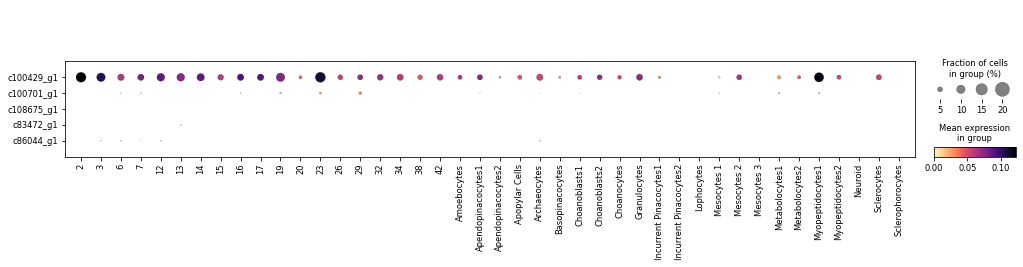

In [27]:
sc.pl.dotplot(adata, groupby='cell_type', var_names=expressed, gene_symbols='gene_id', swap_axes=True, cmap='magma_r')

5/6 are expressed (at least one count), but only two may be _really_ expressed. A bit disappointing that they are broadly distributed and not very specific, but still, it's something.